# Regularization Techniques: Lasso and Ridge Regression

<img src = 'https://drive.google.com/uc?id=1WC7SSdfFseYRgmZ6lbodv898zi2nquJ0' width = 80%>

## Introduction and Dataset

### Background

*regularization + lasso/ridge regression background*


### Tutorial goals

*goals here*

**Goal 1: Model quadratic mean diameter (QMD), aboveground biomass (AGB), and basal area using ridge and lasso regression**

-----

**Notes:**

- *notes here*

### Data

*data description here*

Please refer to the README on the main GitHub page for a detailed description of each file.


### Packages

*relevant packages here*




# Install and load packages

**Uncomment the cell below to install required packages**

In [49]:
# !pip install pandas==2.2.2
# !pip install geopandas==1.0.1
# !pip install matplotlib==3.10.1
# !pip install rioxarray==0.19.0
# !pip install laspy[lazrs]==2.5.4

In [50]:
import os
import pandas as pd
import geopandas as gpd
import rioxarray as rio
from math import sqrt

# Download data

In [51]:
# Download the data if it does not yet exist
if not os.path.exists("data"):
  !gdown 1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
  !unzip prf_data.zip -d data/
  os.remove("prf_data.zip")
else:
  print("Data has already been downloaded.")

os.listdir("data")

Data has already been downloaded.


['boundary.gpkg',
 'forest_point_cloud.las',
 'forest_point_cloud_footprint.gpkg',
 'original',
 'p99.tif',
 'petawawa_s2_2018.tif',
 'petawawa_s2_2024.tif',
 'plots.gpkg',
 'trees.csv',
 'water.gpkg']

# Data Visualization

In [52]:
# Load the 99th height percentile raster
p99 = rio.open_rasterio(r'data/p99.tif')
p99

<xarray.DataArray (band: 1, y: 366, x: 746)> Size: 1MB
[273036 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 6kB 2.974e+05 2.974e+05 ... 3.16e+05 3.16e+05
  * y            (y) float64 3kB 5.099e+06 5.099e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Attributes:
    STATISTICS_MAXIMUM:      45.569999694824
    STATISTICS_MEAN:         25.239122333602
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       5.3449476495645
    AREA_OR_POINT:           Area
    _FillValue:              -3.4028235e+38
    scale_factor:            1.0
    add_offset:              0.0

# Preprocessing

In [53]:

trees_df = gpd.read_file(r'data/trees.csv')

plots_gdf = gpd.read_file(r'data/plots.gpkg')



In [54]:
# Ensure multiple columns in trees df are numeric
cols_to_convert = ['biomass', 'height', 'baha', 'DBH']
for col in cols_to_convert:
    trees_df[col] = pd.to_numeric(trees_df[col])

trees_df

,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size
0,PRF001,24.0,White pine,P,D,10.1,,1.0,11.552521,0.128190,N,0.0,0.7087347141,393.396400,Poles
1,PRF001,46.0,White pine,P,D,9.9,,2.0,11.422529,0.123163,N,0.0,0.6732544319,375.305379,Poles
2,PRF001,20.0,Red pine,N,L,67.5,D,,33.900000,5.725566,Y,77.327438489,79.482658012,39691.639950,Large
3,PRF001,50.0,Red pine,N,L,57.9,D,,32.528851,4.212773,Y,56.444280856,58.117291913,28251.255888,Large
4,PRF001,10.0,White pine,N,L,55.9,D,,33.000000,3.926761,Y,48.008649036,49.833742798,24501.838779,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12585,PRF334,,Sugar Maple,N,L,3.7,,,8.893640,0.215043,N,0.0,0.8585643577,851.191939,Under
12586,PRF334,,Sugar Maple,N,L,3.3,,,8.500000,0.171060,N,0.0,0.6538680809,659.084439,Under
12587,PRF334,,Sugar Maple,N,L,3.2,,,8.395967,0.160850,N,0.0,0.607492501,615.333049,Under
12588,PRF334,,Sugar Maple,N,L,3.0,,,7.400000,0.141372,N,0.0,0.4696555303,521.064025,Under


In [55]:
# Check the range of various tree attributes
trees_df.describe()

,DBH,height,baha,biomass
count,12590.000000,12590.000000,12590.000000,12342.000000
mean,17.622415,15.883219,0.602011,3286.085532
std,11.559345,6.713323,0.895101,6305.457552
min,2.500000,1.301584,0.070686,138.409692
25%,10.600000,11.531384,0.174975,634.448847
50%,14.500000,14.907205,0.309749,1266.913205
75%,21.100000,19.398785,0.623451,2800.442589
max,97.500000,50.300000,11.945934,89100.864298


  PlotName        qmd
0   PRF001  17.404048
1   PRF002  15.516198
2   PRF003  21.552772
3   PRF004  24.552552
4   PRF005  32.004159


<Axes: >

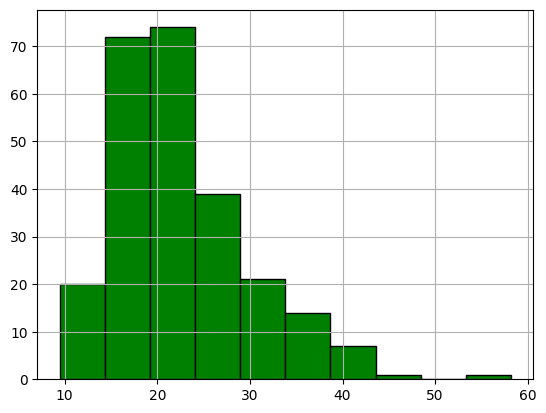

In [56]:
# Calculate the Qaudratic Mean Diameter (QMD)

qmd_ls = []
plot_id_ls = trees_df['PlotName'].unique()

for plot_id in plot_id_ls:
    
    plot_trees_df = trees_df[trees_df['PlotName'] == plot_id]

    n_trees = plot_trees_df['DBH'].count()

    dbhs_squared = plot_trees_df['DBH'].apply(lambda x: x**2)

    sum_squares = dbhs_squared.sum()

    qmd = sqrt(sum_squares / n_trees)

    qmd_ls.append(qmd)

qdm_df = pd.DataFrame({
    'PlotName': plot_id_ls,
    'qmd': qmd_ls
})

print(qdm_df.head())

# Plot QDM
qdm_df['qmd'].hist(edgecolor='black', color='green')

In [57]:
# Note that each plot has a radius of 14.1m (625m^2) 
# We need to convert to hectares, since this is the most common areal unit in forestry.
# There are 10000 m^2 in a hectare, so we divide by 10000.

plot_area_m2 = 625

plot_area_ha = plot_area_m2 / 10000

plot_area_ha

0.0625

In [ ]:
#STEP 1: Calculate plot-level aboveground biomass (AGB)

# Convert tree-level biomass from Kg/ha to Kg, and then to Mg (tonnes).
trees_df['biomass_kg'] = trees_df['biomass'] * plot_area_ha
trees_df['biomass_Mg'] = trees_df['biomass_kg'] / 1000  

biomass_df = (trees_df.groupby('PlotName').
                    agg(biomass_Mg_total=('biomass_Mg', 'sum')).
                    assign(biomass_Mg_ha=lambda x: x['biomass_Mg_total'] / plot_area_ha))

# Summarize biomass
biomass_df.describe()

# STEP 2: Calculate the plot-level basal area (BA)



,biomass_Mg_total,biomass_Mg_ha
count,249.000000,249.000000
mean,10.179937,162.878987
std,5.571596,89.145529
min,0.146435,2.342960
25%,6.375452,102.007230
50%,9.263491,148.215860
75%,12.238090,195.809442
max,35.127161,562.034569
